<a href="https://colab.research.google.com/github/IgnacioMenna/Proyectos-Data-Science-ML/blob/main/kaggle_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques
import zipfile

with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip", 'r') as zip_ref:
    zip_ref.extractall("house-prices-advanced-regression-techniques_data")

Saving kaggle.json to kaggle (1).json
house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
%pip install catboost

# Import Packages

In [8]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

from math import sqrt
from sklearn.model_selection import KFold, cross_val_score

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns', None)

# Load The Datasets

In [9]:
df_train = pd.read_csv("house-prices-advanced-regression-techniques_data/train.csv")
df_test = pd.read_csv("house-prices-advanced-regression-techniques_data/test.csv")
sample_submission = pd.read_csv("house-prices-advanced-regression-techniques_data/sample_submission.csv")
print("train data shape is {}" .format(df_train.shape))
print("test data shape is {}" .format(df_test.shape))

train data shape is (1460, 81)
test data shape is (1459, 80)


In [10]:
# Check for duplicates in train set
df_train.duplicated().sum()

np.int64(0)

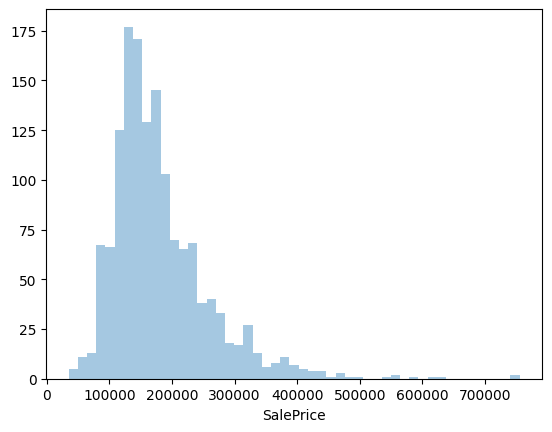

In [11]:
# Distribution of values in target feature
sns.distplot(df_train.get('SalePrice'), kde=False)
plt.show()

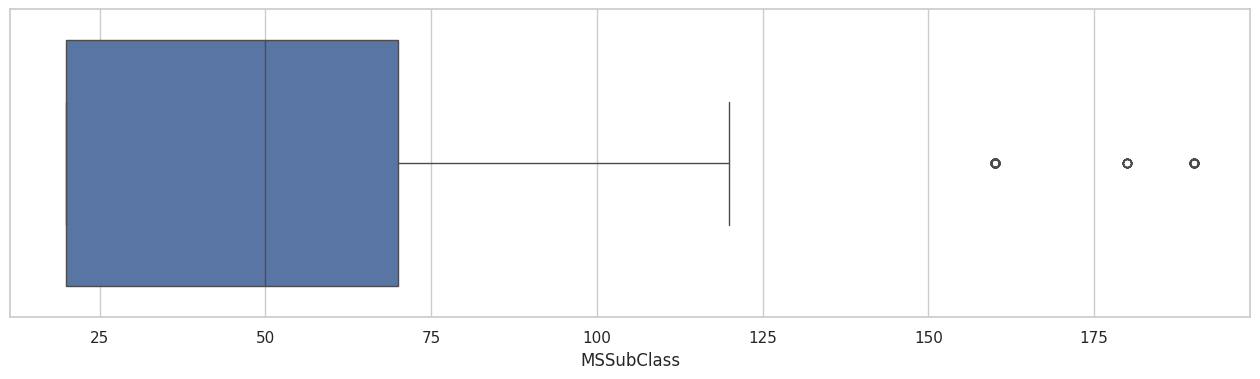

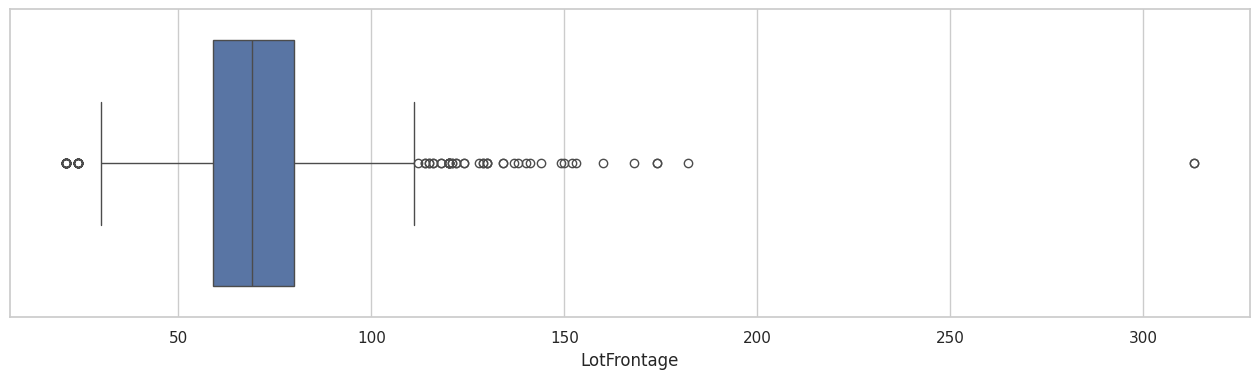

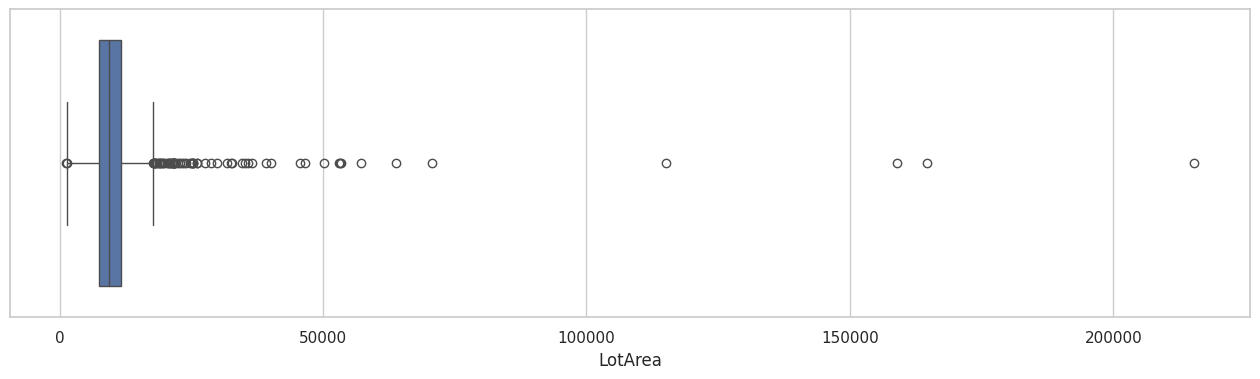

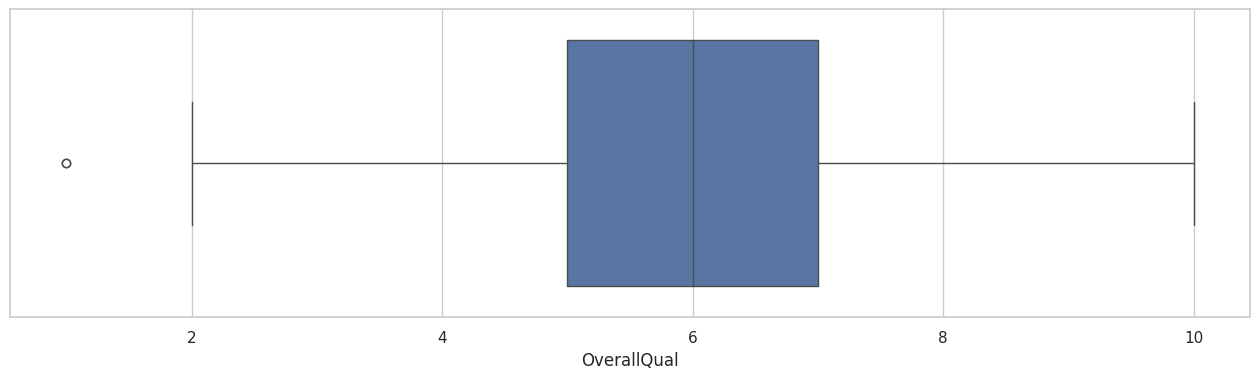

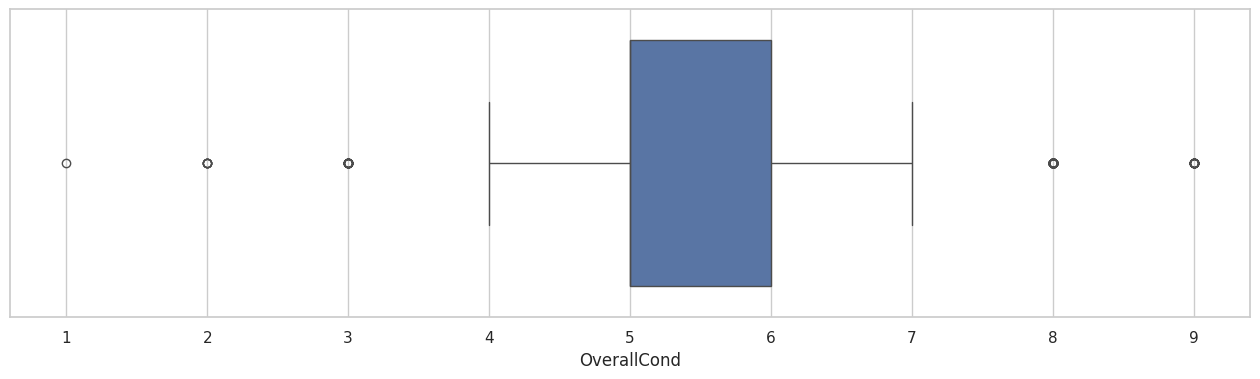

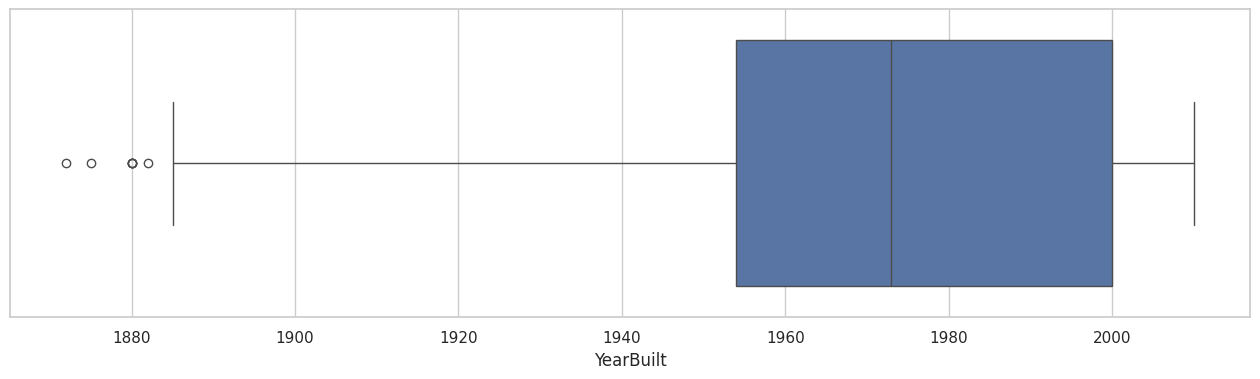

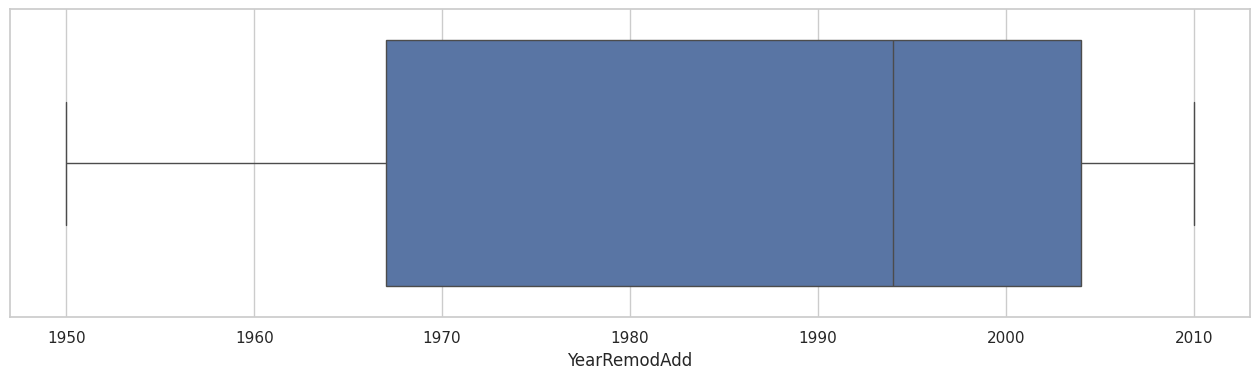

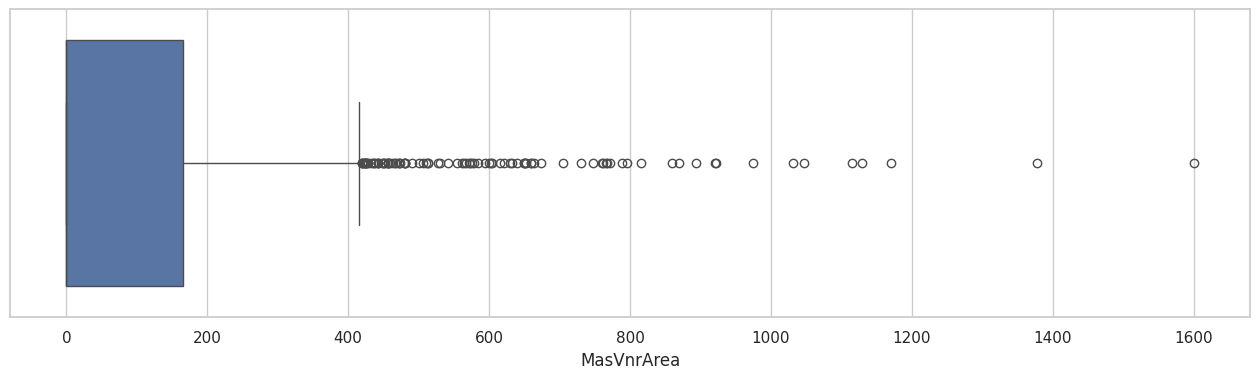

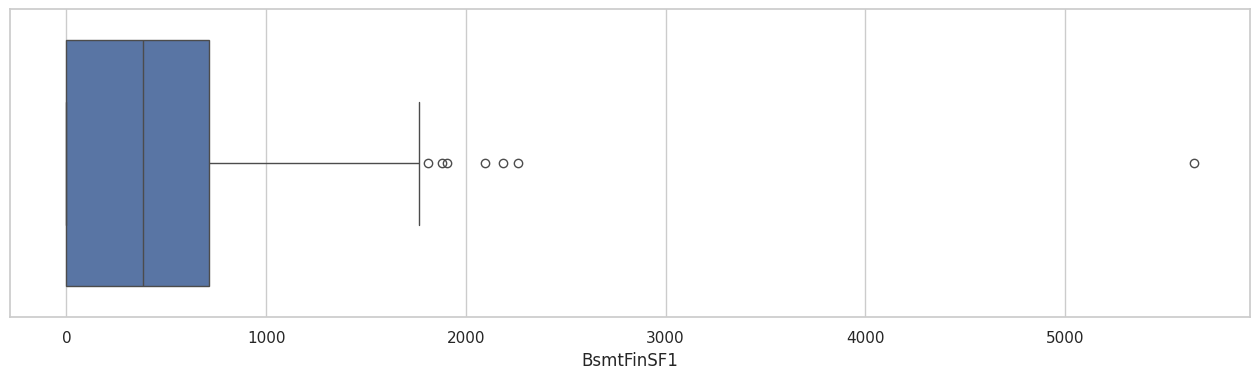

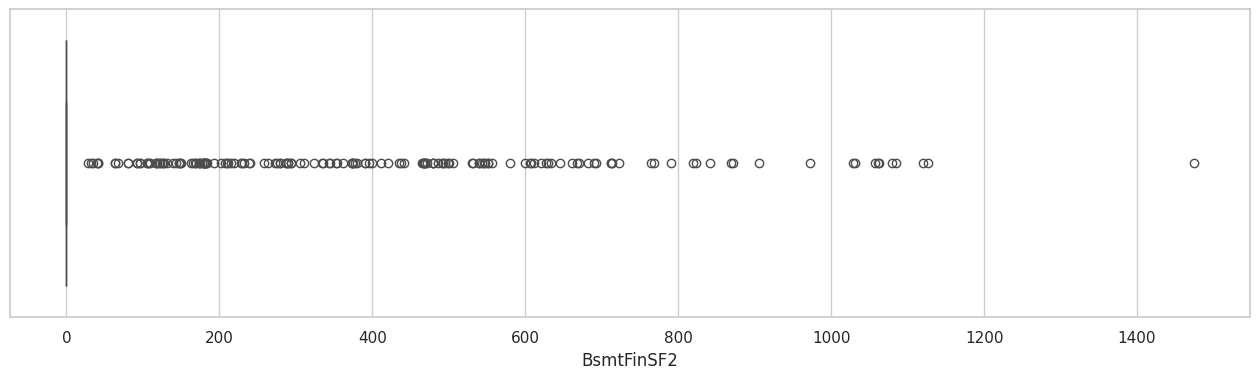

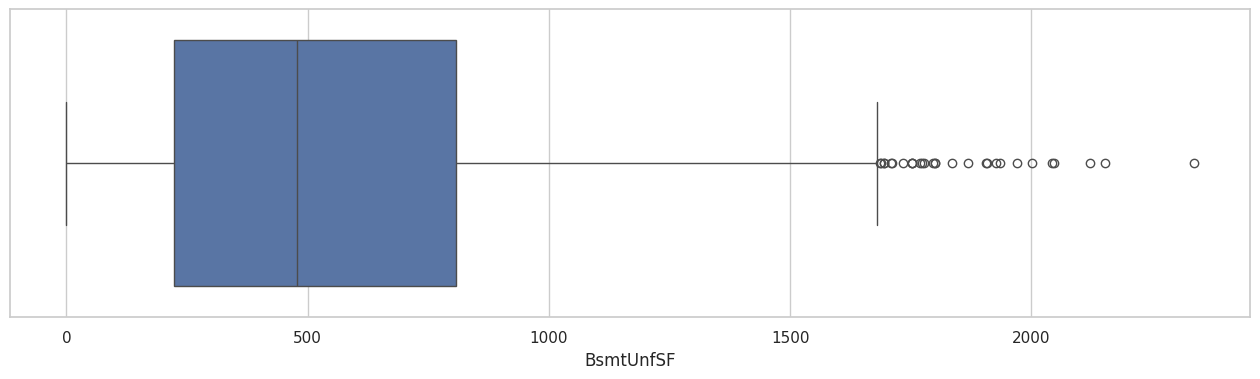

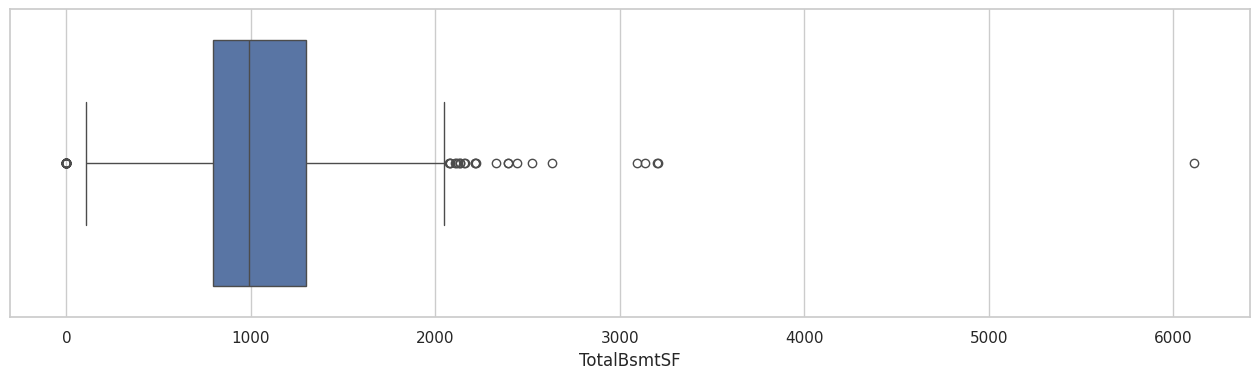

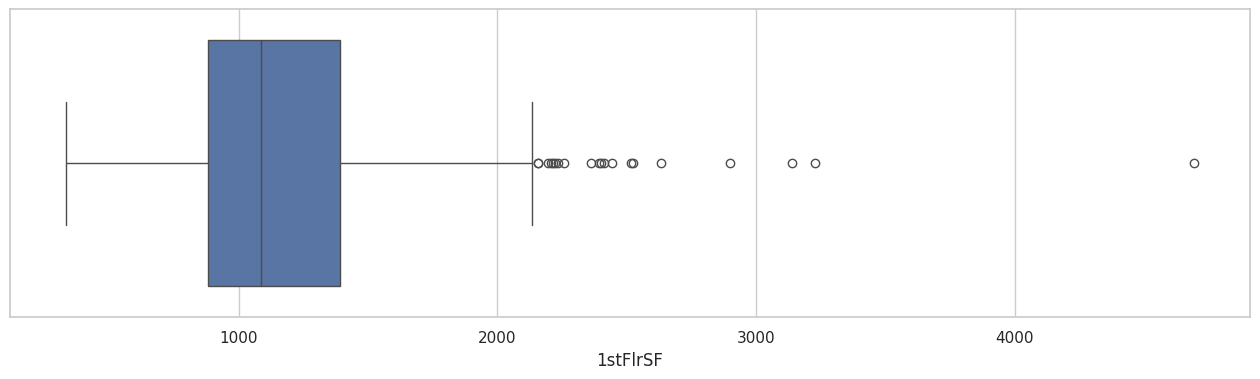

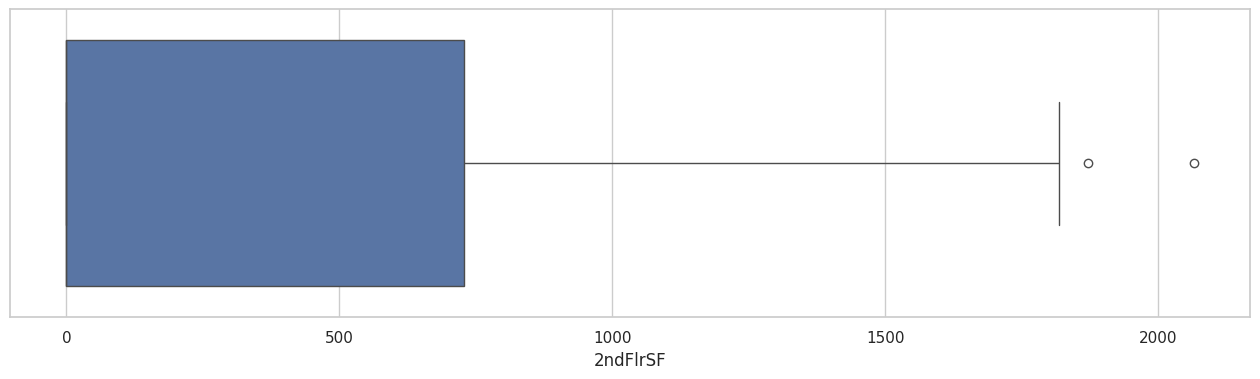

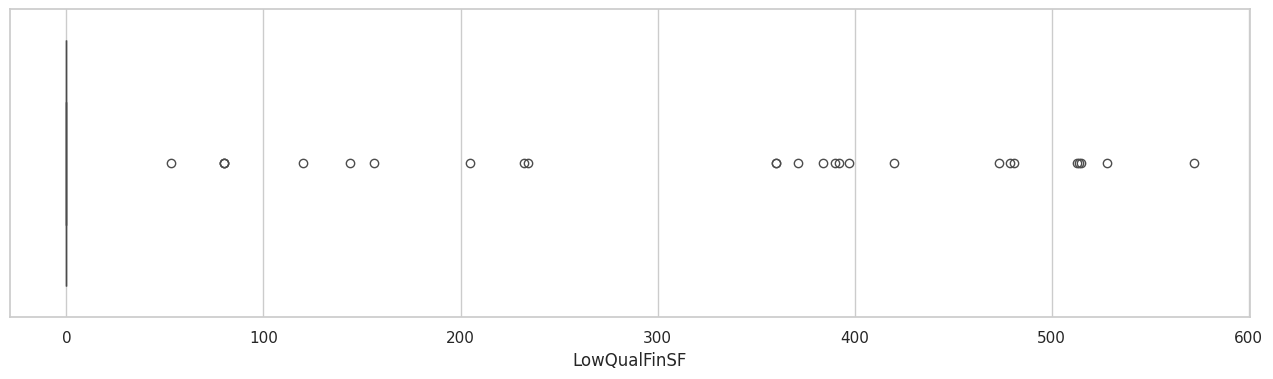

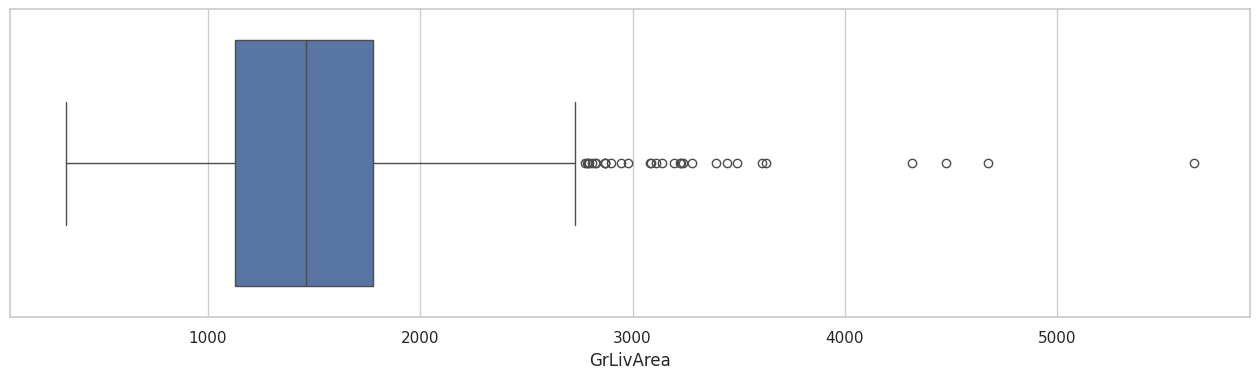

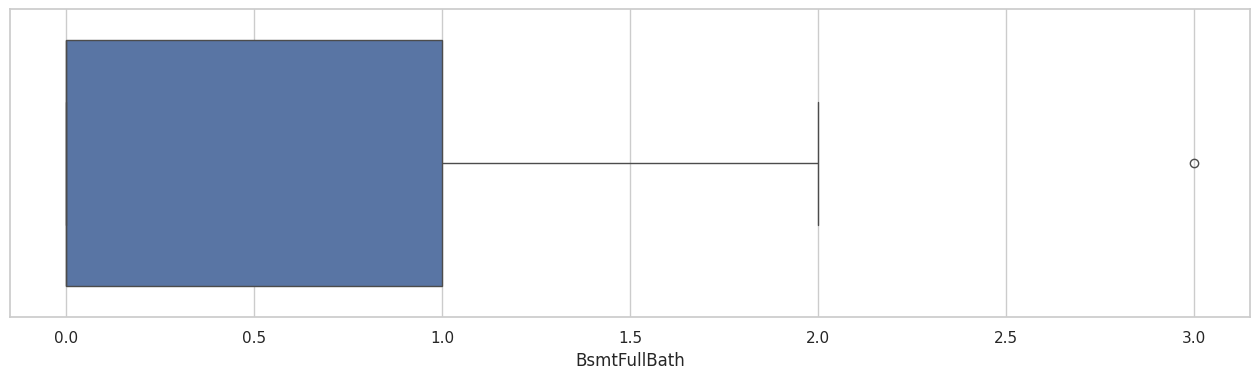

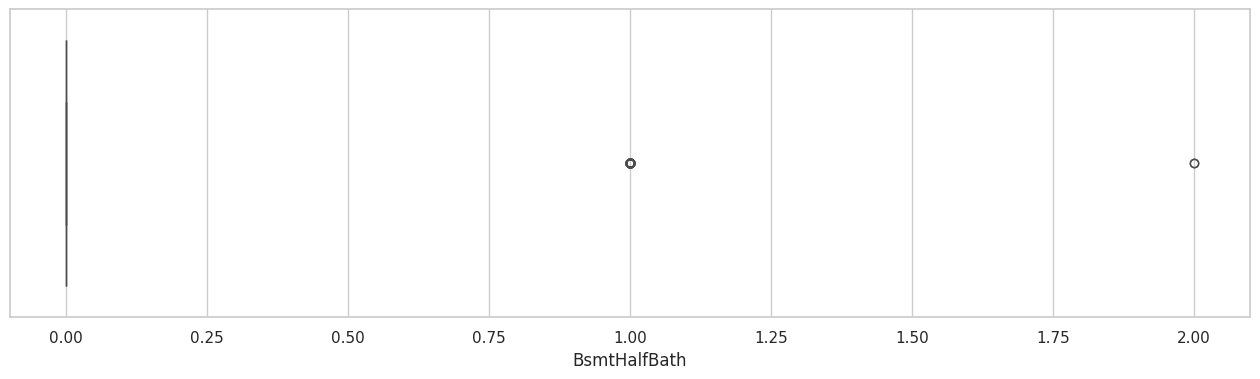

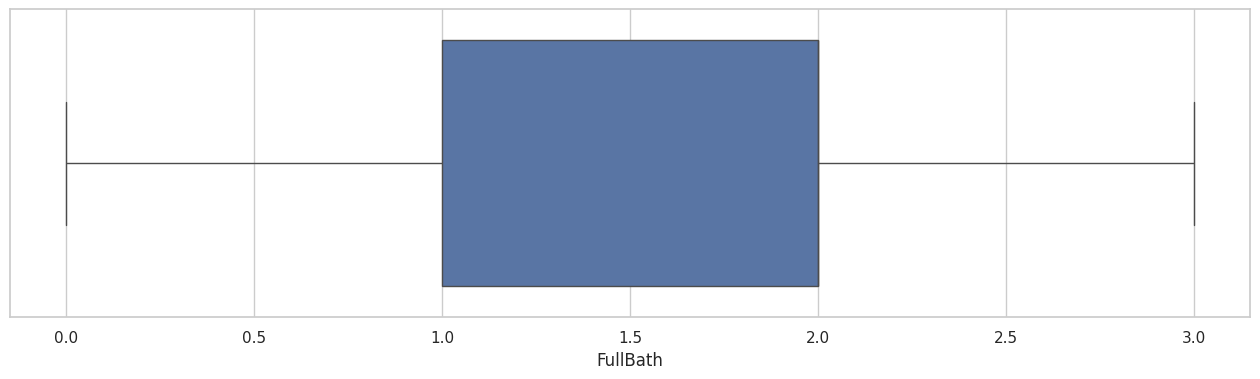

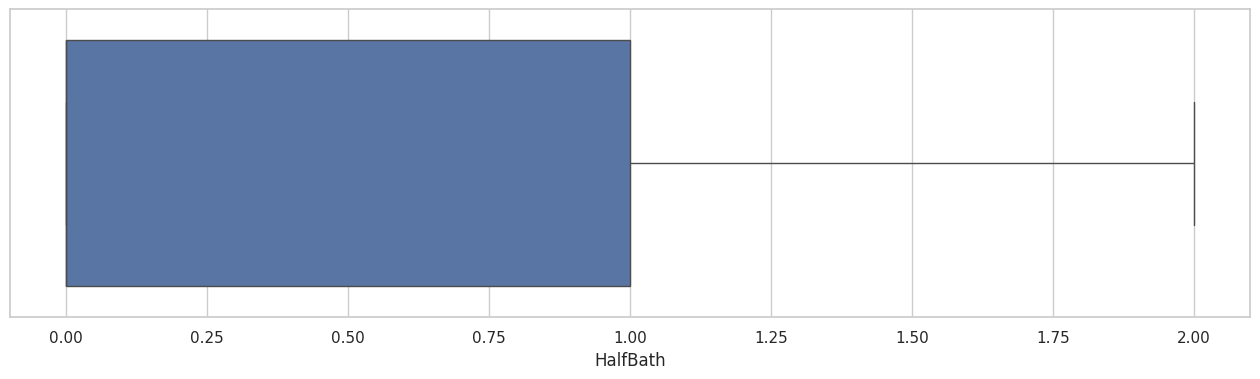

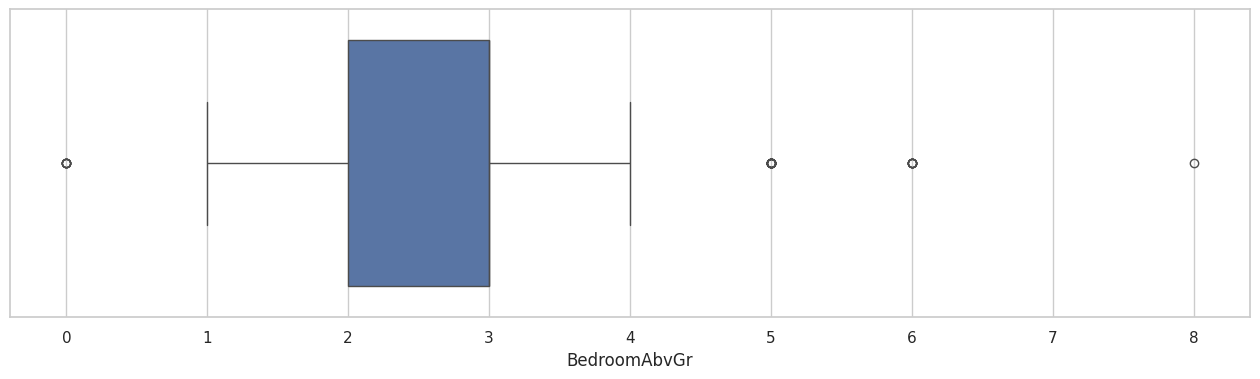

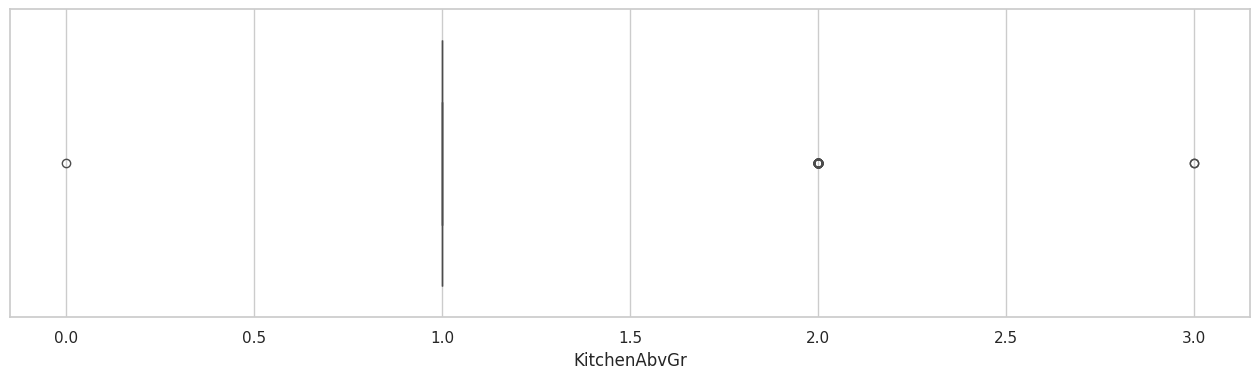

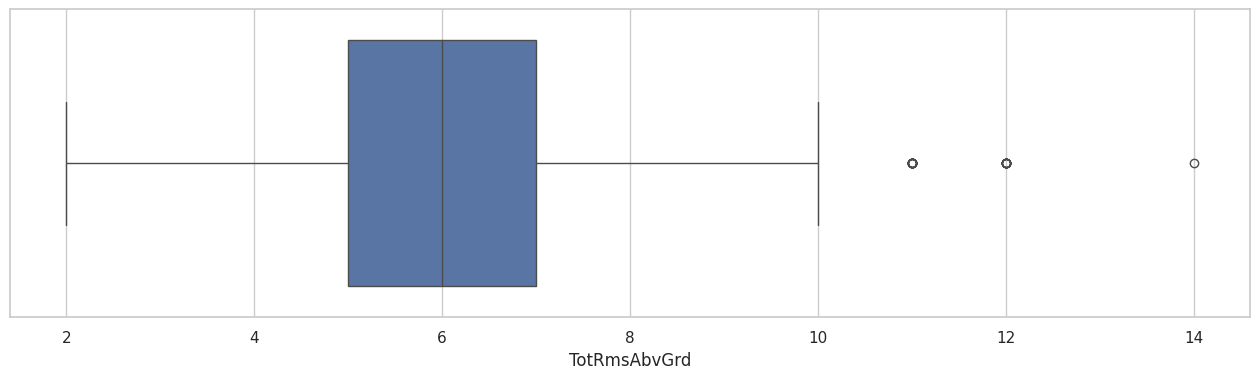

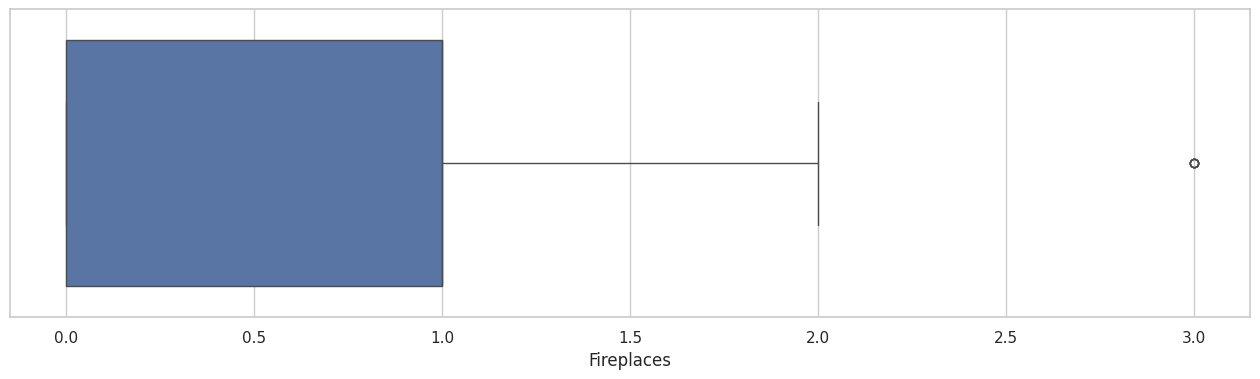

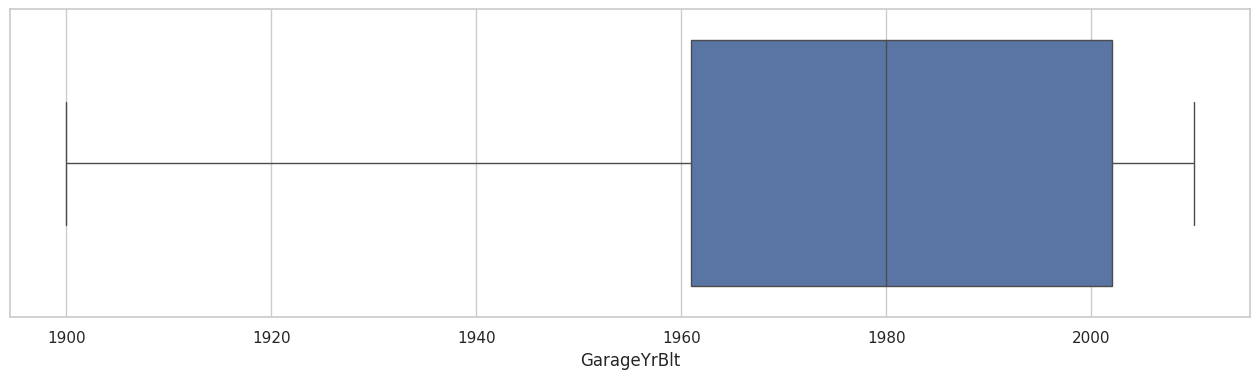

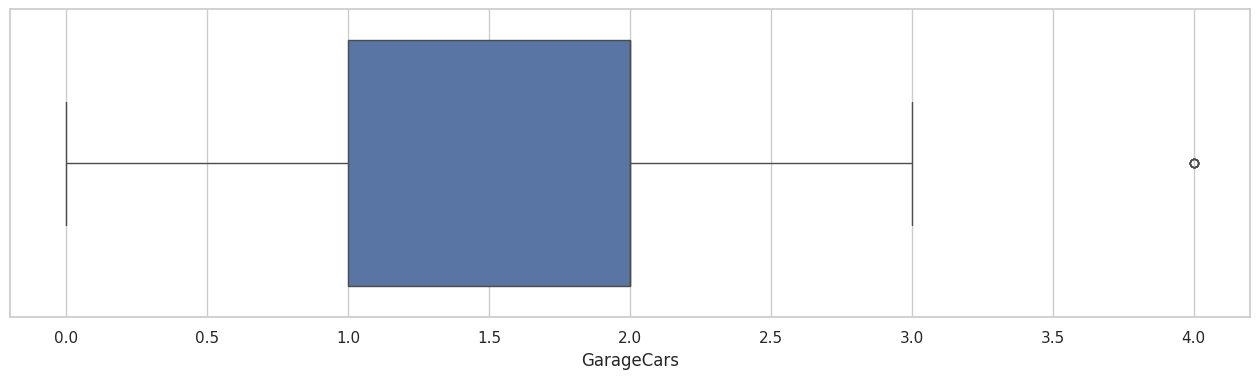

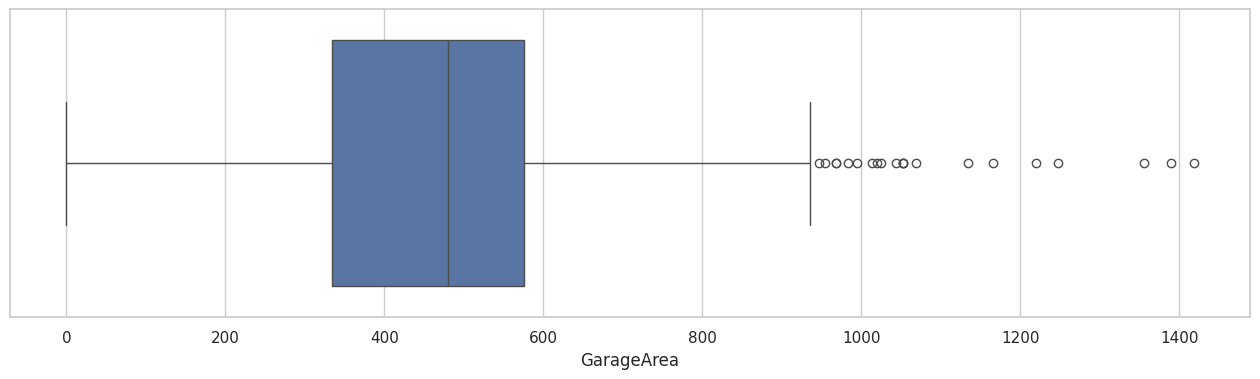

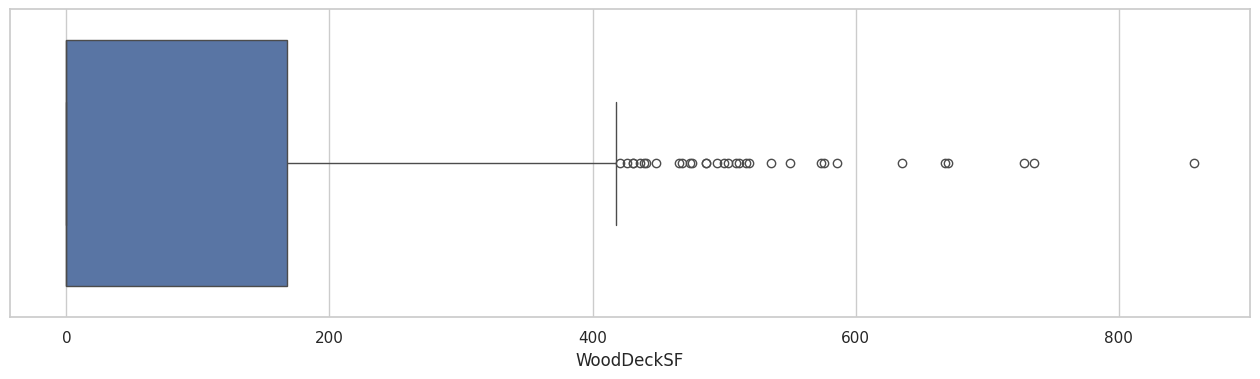

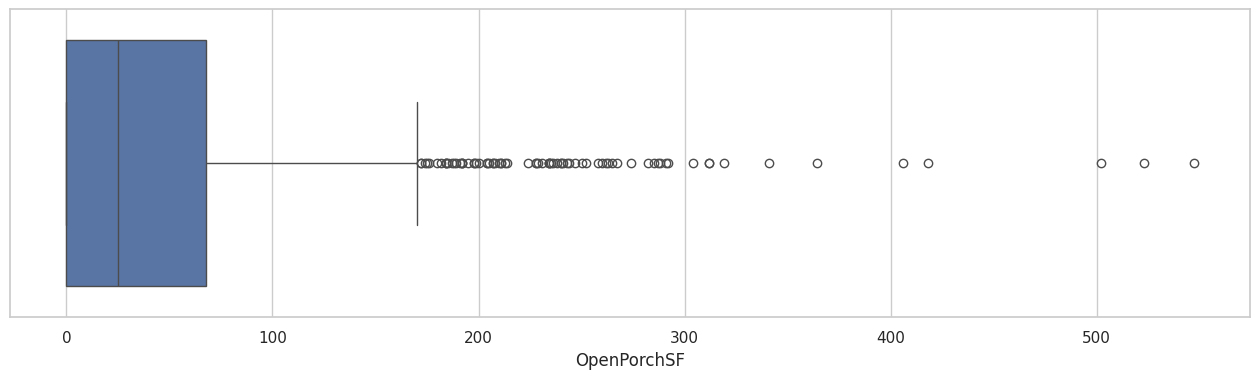

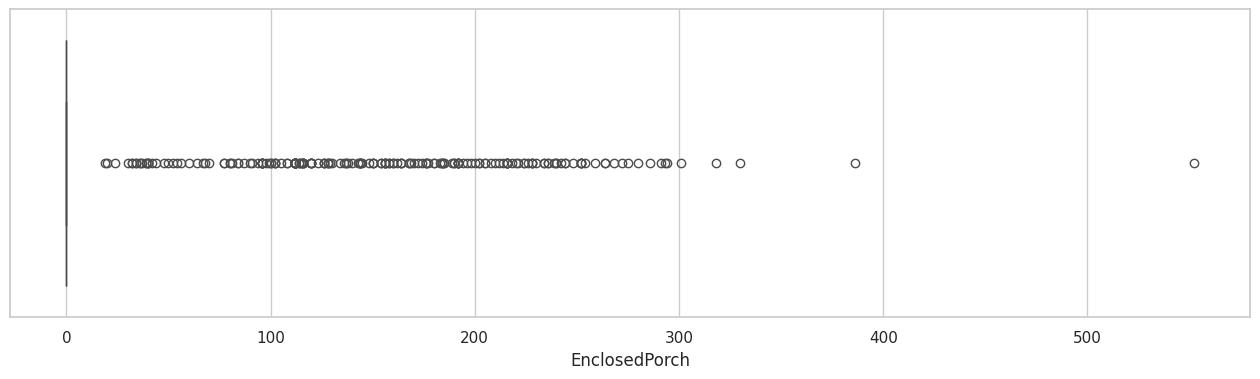

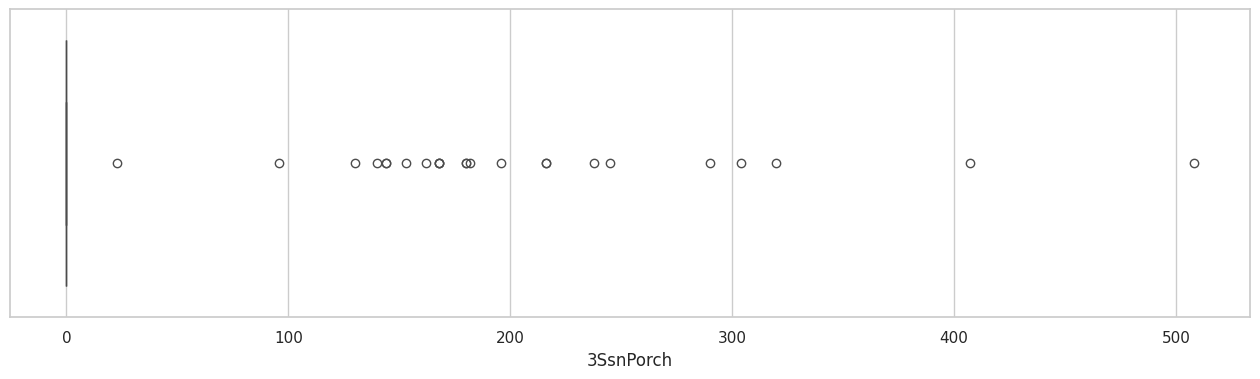

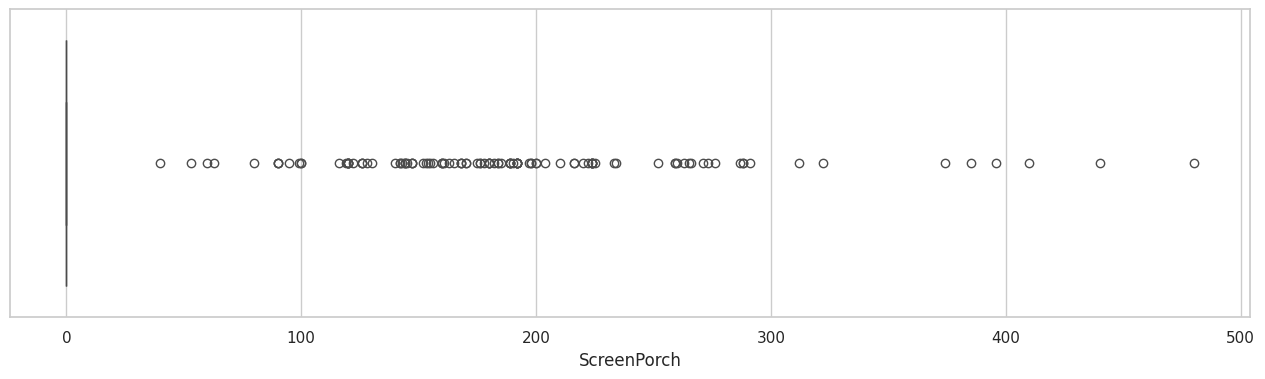

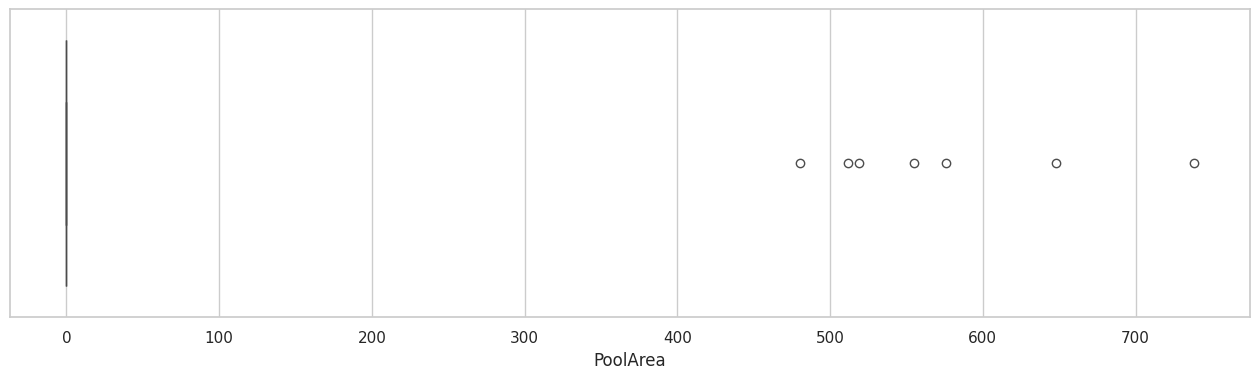

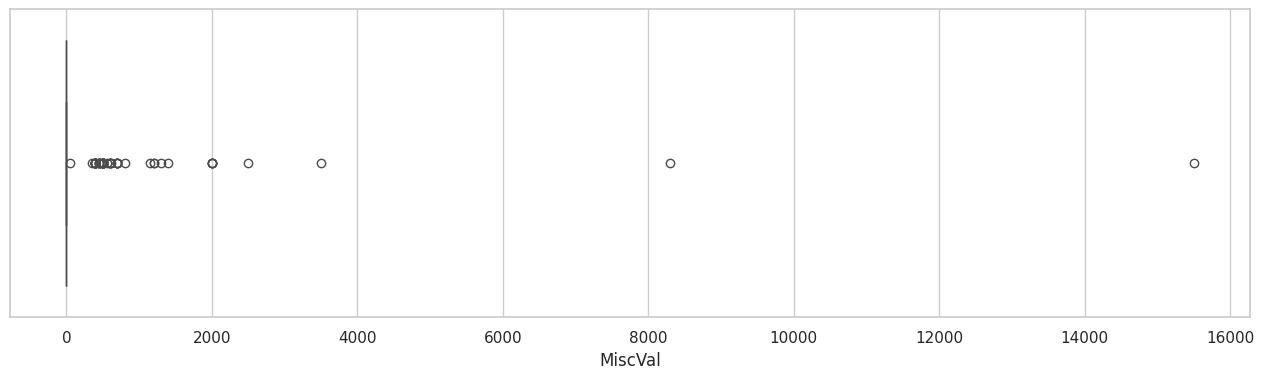

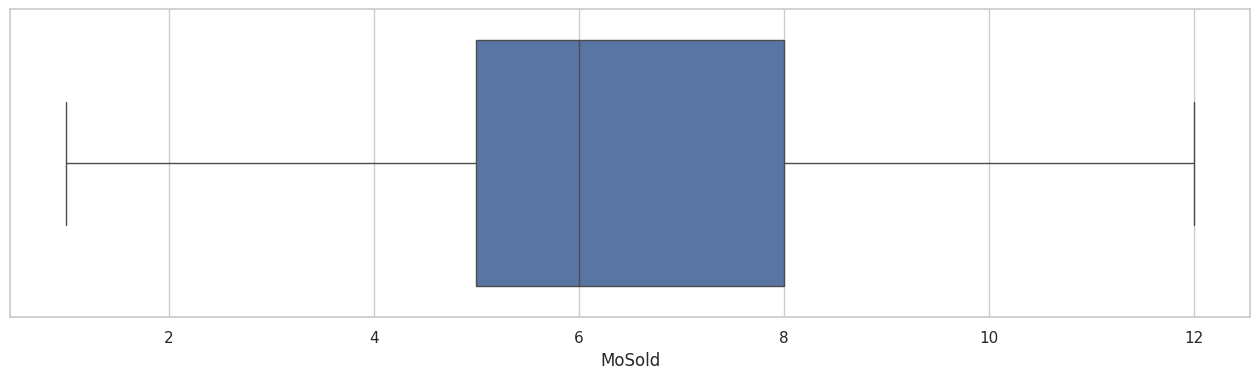

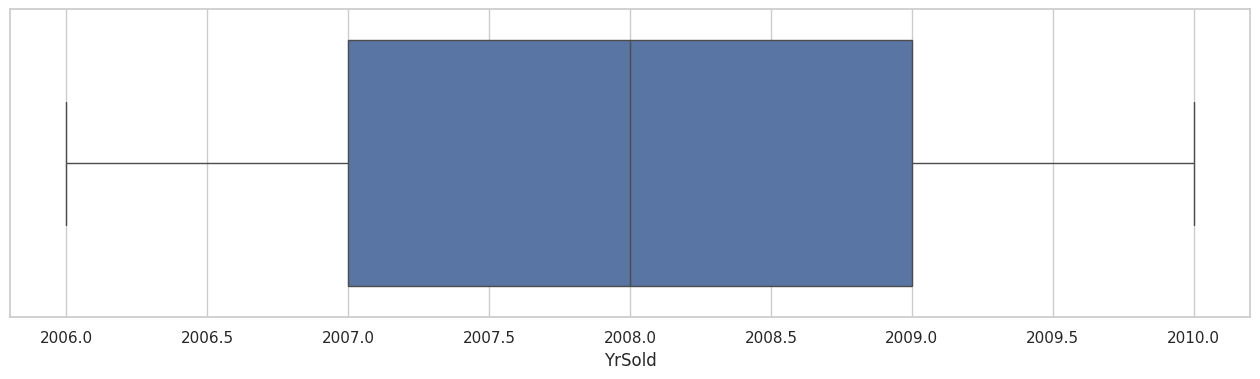

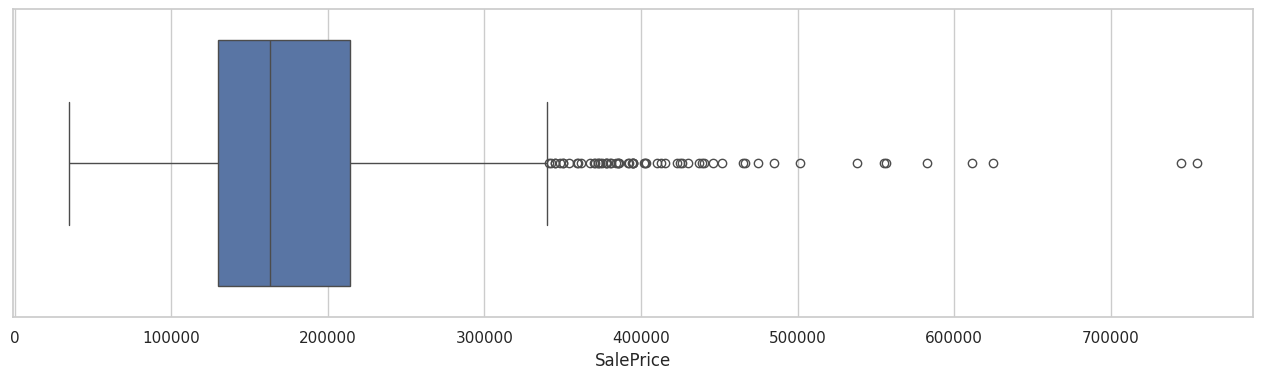

In [12]:
# Find outliers for all numerical dataset (before handling missing values)

numerical_df = df_train.select_dtypes(exclude=['object'])
numerical_df = numerical_df.drop('Id', axis=1)

for column in numerical_df:
  plt.figure(figsize=(16, 4))
  sns.set_theme(style="whitegrid")
  sns.boxplot(numerical_df[column], orient='h')
  plt.xlabel(column)
  plt.show()

From the images above, it can be inferred that there are outliers in the data. We will not delete the rows containing the outliers for the changes that it might destroy some important data. The outliers will have to be handled later.

In [13]:
# Merge the dataframes together
df_combined = pd.concat([df_train, df_test])

# Reset the index
df_combined.reset_index(drop=True, inplace=True)

df_combined.shape

(2919, 81)

In [14]:
df_combined.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


# Fill missing data

In [15]:
# Find out missing rows

df_combined.isnull().sum().sort_values(ascending=False).head(36)

,0
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
MasVnrType,1766
SalePrice,1459
FireplaceQu,1420
LotFrontage,486
GarageCond,159
GarageYrBlt,159


In [16]:
print(df_combined['PoolQC'].unique())
print("")
print(df_combined['PoolQC'].value_counts())

[nan 'Ex' 'Fa' 'Gd']

PoolQC
Ex    4
Gd    4
Fa    2
Name: count, dtype: int64


In [17]:
df_combined['PoolQC'].fillna('None', inplace=True)

In [18]:
print(df_combined['MiscFeature'].unique())
print("")
print(df_combined['MiscFeature'].value_counts())

[nan 'Shed' 'Gar2' 'Othr' 'TenC']

MiscFeature
Shed    95
Gar2     5
Othr     4
TenC     1
Name: count, dtype: int64


In [19]:
df_combined['MiscFeature'].fillna('None', inplace=True)

In [20]:
print(df_combined['Alley'].unique())
print("")
print(df_combined['Alley'].value_counts())

[nan 'Grvl' 'Pave']

Alley
Grvl    120
Pave     78
Name: count, dtype: int64


In [21]:
df_combined['Alley'].fillna('None', inplace=True)

In [22]:
print(df_combined['Fence'].unique())
print("")
print(df_combined['Fence'].value_counts())

[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']

Fence
MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: count, dtype: int64


In [23]:
df_combined['Fence'].fillna('None', inplace=True)

In [24]:
print(df_combined['MasVnrType'].unique())
print("")
print(df_combined['MasVnrType'].value_counts())

['BrkFace' nan 'Stone' 'BrkCmn']

MasVnrType
BrkFace    879
Stone      249
BrkCmn      25
Name: count, dtype: int64


In [25]:
df_combined['MasVnrType'].fillna('None', inplace=True)

In [26]:
print(df_combined['FireplaceQu'].unique())
print("")
print(df_combined['FireplaceQu'].value_counts())

[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']

FireplaceQu
Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: count, dtype: int64


In [27]:
df_combined['FireplaceQu'].fillna('None', inplace=True)

In [28]:
print(df_combined['LotFrontage'].unique())
print("")
print(df_combined['LotFrontage'].value_counts())

[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.  26.
  25. 119.  31.  28. 117. 113. 125. 135. 136.  22. 123. 195. 155. 126.
 200. 131. 133.]

LotFrontage
60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
        ... 
155.0      1
126.0      1
200.0      1
131.0      1
133.0      1
Name: count, Length: 128, dtype: int64


In [29]:
df_combined['LotFrontage'].fillna(0, inplace=True)

In [30]:
print(df_combined['GarageYrBlt'].unique())
print("")
print(df_combined['GarageYrBlt'].value_counts())

[2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.   nan 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1900. 1979. 1951. 1969. 1936. 1975. 1971.
 1923. 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924.
 1996. 1940. 1949. 1994. 1910. 1978. 1982. 1992. 1925. 1941. 2010. 1927.
 1947. 1937. 1942. 1938. 1952. 1928. 1922. 1934. 1906. 1914. 1946. 1908.
 1929. 1933. 1917. 1896. 1895. 2207. 1943. 1919.]

GarageYrBlt
2005.0    142
2006.0    115
2007.0    115
2004.0     99
2003.0     92
         ... 
1896.0      1
1895.0      1
2207.0      1
1943.0      1
1919.0      1
Name: count, Length: 103, dtype: int64


In [31]:
df_combined['GarageYrBlt'].fillna(0, inplace=True)

In [32]:
# Fix error of 2207 year entry to 2007
df_combined['GarageYrBlt'] = df_combined['GarageYrBlt'].replace(2207, 2007)

In [33]:
print(df_combined['GarageFinish'].unique())
print("")
print(df_combined['GarageFinish'].value_counts())

['RFn' 'Unf' 'Fin' nan]

GarageFinish
Unf    1230
RFn     811
Fin     719
Name: count, dtype: int64


In [34]:
df_combined['GarageFinish'].fillna('None', inplace=True)

In [35]:
print(df_combined['GarageQual'].unique())
print("")
print(df_combined['GarageQual'].value_counts())

['TA' 'Fa' 'Gd' nan 'Ex' 'Po']

GarageQual
TA    2604
Fa     124
Gd      24
Po       5
Ex       3
Name: count, dtype: int64


In [36]:
df_combined['GarageQual'].fillna('None', inplace=True)

In [37]:
print(df_combined['GarageCond'].unique())
print("")
print(df_combined['GarageCond'].value_counts())

['TA' 'Fa' nan 'Gd' 'Po' 'Ex']

GarageCond
TA    2654
Fa      74
Gd      15
Po      14
Ex       3
Name: count, dtype: int64


In [38]:
df_combined['GarageCond'].fillna('None', inplace=True)

In [39]:
print(df_combined['GarageType'].unique())
print("")
print(df_combined['GarageType'].value_counts())

['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']

GarageType
Attchd     1723
Detchd      779
BuiltIn     186
Basment      36
2Types       23
CarPort      15
Name: count, dtype: int64


In [40]:
df_combined['GarageType'].fillna('None', inplace=True)

In [41]:
print(df_combined['BsmtExposure'].unique())
print("")
print(df_combined['BsmtExposure'].value_counts())

['No' 'Gd' 'Mn' 'Av' nan]

BsmtExposure
No    1904
Av     418
Gd     276
Mn     239
Name: count, dtype: int64


In [42]:
df_combined['BsmtExposure'].fillna('None', inplace=True)

In [43]:
print(df_combined['BsmtCond'].unique())
print("")
print(df_combined['BsmtCond'].value_counts())

['TA' 'Gd' nan 'Fa' 'Po']

BsmtCond
TA    2606
Gd     122
Fa     104
Po       5
Name: count, dtype: int64


In [44]:
df_combined['BsmtCond'].fillna('None', inplace=True)

In [45]:
print(df_combined['BsmtQual'].unique())
print("")
print(df_combined['BsmtQual'].value_counts())

['Gd' 'TA' 'Ex' nan 'Fa']

BsmtQual
TA    1283
Gd    1209
Ex     258
Fa      88
Name: count, dtype: int64


In [46]:
df_combined['BsmtQual'].fillna('None', inplace=True)

In [47]:
print(df_combined['BsmtFinType2'].unique())
print("")
print(df_combined['BsmtFinType2'].value_counts())

['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']

BsmtFinType2
Unf    2493
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: count, dtype: int64


In [48]:
df_combined['BsmtFinType2'].fillna('None', inplace=True)

In [49]:
print(df_combined['BsmtFinType1'].unique())
print("")
print(df_combined['BsmtFinType1'].value_counts())

['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']

BsmtFinType1
Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: count, dtype: int64


In [50]:
df_combined['BsmtFinType1'].fillna('None', inplace=True)

In [51]:
#print(df_combined['MasVnrArea'].unique())
print("")
print(df_combined['MasVnrArea'].value_counts())


MasVnrArea
0.0      1738
120.0      15
200.0      13
176.0      13
216.0      12
         ... 
355.0       1
405.0       1
327.0       1
257.0       1
382.0       1
Name: count, Length: 444, dtype: int64


In [52]:
df_combined['MasVnrArea'].fillna(0, inplace=True)

In [53]:
print(df_combined['MSZoning'].unique())
print("")
print(df_combined['MSZoning'].value_counts())

['RL' 'RM' 'C (all)' 'FV' 'RH' nan]

MSZoning
RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: count, dtype: int64


In [54]:
df_combined['MSZoning'].fillna('RL', inplace=True)

In [55]:
print(df_combined['Functional'].unique())
print("")
print(df_combined['Functional'].value_counts())

['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev' nan]

Functional
Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: count, dtype: int64


In [56]:
df_combined['Functional'].fillna('Typ', inplace=True)

In [57]:
print(df_combined['BsmtFullBath'].unique())
print("")
print(df_combined['BsmtFullBath'].value_counts())

[ 1.  0.  2.  3. nan]

BsmtFullBath
0.0    1705
1.0    1172
2.0      38
3.0       2
Name: count, dtype: int64


In [58]:
df_combined['BsmtFullBath'].fillna(0, inplace=True)

In [59]:
print(df_combined['Utilities'].unique())
print("")
print(df_combined['Utilities'].value_counts())

['AllPub' 'NoSeWa' nan]

Utilities
AllPub    2916
NoSeWa       1
Name: count, dtype: int64


In [60]:
df_combined['Utilities'].fillna('AllPub', inplace=True)

In [61]:
print(df_combined['BsmtHalfBath'].unique())
print("")
print(df_combined['BsmtHalfBath'].value_counts())

[ 0.  1.  2. nan]

BsmtHalfBath
0.0    2742
1.0     171
2.0       4
Name: count, dtype: int64


In [62]:
df_combined['BsmtHalfBath'].fillna(0, inplace=True)

In [63]:
print(df_combined['Electrical'].unique())
print("")
print(df_combined['Electrical'].value_counts())

['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]

Electrical
SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: count, dtype: int64


In [64]:
df_combined['Electrical'].fillna('SBrkr', inplace=True)

In [65]:
print(df_combined['TotalBsmtSF'].unique())
print("")
print(df_combined['TotalBsmtSF'].value_counts())

[ 856. 1262.  920. ...  498.  432. 1381.]

TotalBsmtSF
0.0       78
864.0     74
672.0     29
912.0     26
1040.0    25
          ..
1428.0     1
673.0      1
1241.0     1
1225.0     1
485.0      1
Name: count, Length: 1058, dtype: int64


In [66]:
df_combined['TotalBsmtSF'].fillna(0, inplace=True)

In [67]:
print(df_combined['BsmtUnfSF'].unique())
print("")
print(df_combined['BsmtUnfSF'].value_counts())

[ 150.  284.  434. ...  129.   45. 1503.]

BsmtUnfSF
0.0       241
384.0      19
728.0      14
672.0      13
600.0      12
         ... 
231.0       1
109.0       1
951.0       1
1105.0      1
517.0       1
Name: count, Length: 1135, dtype: int64


In [68]:
df_combined['BsmtUnfSF'].fillna(0, inplace=True)

In [69]:
print(df_combined['KitchenQual'].unique())
print("")
print(df_combined['KitchenQual'].value_counts())

['Gd' 'TA' 'Ex' 'Fa' nan]

KitchenQual
TA    1492
Gd    1151
Ex     205
Fa      70
Name: count, dtype: int64


In [70]:
df_combined['KitchenQual'].fillna('None', inplace=True)

In [71]:
print(df_combined['BsmtFinSF2'].unique())
print("")
print(df_combined['BsmtFinSF2'].value_counts())

[   0.   32.  668.  486.   93.  491.  506.  712.  362.   41.  169.  869.
  150.  670.   28. 1080.  181.  768.  215.  374.  208.  441.  184.  279.
  306.  180.  580.  690.  692.  228.  125. 1063.  620.  175.  820. 1474.
  264.  479.  147.  232.  380.  544.  294.  258.  121.  391.  531.  344.
  539.  713.  210.  311. 1120.  165.  532.   96.  495.  174. 1127.  139.
  202.  645.  123.  551.  219.  606.  612.  480.  182.  132.  336.  468.
  287.   35.  499.  723.  119.   40.  117.  239.   80.  472.   64. 1057.
  127.  630.  128.  377.  764.  345. 1085.  435.  823.  500.  290.  324.
  634.  411.  841. 1061.  466.  396.  354.  149.  193.  273.  465.  400.
  682.  557.  230.  106.  791.  240.  547.  469.  177.  108.  600.  492.
  211.  168. 1031.  438.  375.  144.   81.  906.  608.  276.  661.   68.
  173.  972.  105.  420.  546.  334.  352.  872.  110.  627.  163. 1029.
   78.  859.  981.   42.   46.  162.  350.  263. 1073.   12.  159.  474.
  453.  684.  387.  688.  252.  590.  284.  622.  1

In [72]:
df_combined['BsmtFinSF2'].fillna(0, inplace=True)

In [73]:
#print(df_combined['BsmtFinSF1'].unique())
print("")
print(df_combined['BsmtFinSF1'].value_counts())


BsmtFinSF1
0.0       929
24.0       27
16.0       14
300.0       9
20.0        8
         ... 
951.0       1
382.0       1
373.0       1
1505.0      1
1290.0      1
Name: count, Length: 991, dtype: int64


In [74]:
df_combined['BsmtFinSF1'].fillna(0, inplace=True)

In [75]:
print(df_combined['SaleType'].unique())
print("")
print(df_combined['SaleType'].value_counts())

['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth' nan]

SaleType
WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: count, dtype: int64


In [76]:
df_combined['SaleType'].fillna('WD', inplace=True)

In [77]:
print(df_combined['GarageCars'].unique())
print("")
print(df_combined['GarageCars'].value_counts())

[ 2.  3.  1.  0.  4.  5. nan]

GarageCars
2.0    1594
1.0     776
3.0     374
0.0     157
4.0      16
5.0       1
Name: count, dtype: int64


In [78]:
df_combined['GarageCars'].fillna(0, inplace=True)

In [79]:
print(df_combined['Exterior2nd'].unique())
print("")
print(df_combined['Exterior2nd'].value_counts())

['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock' nan]

Exterior2nd
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
BrkFace      47
Stucco       47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: count, dtype: int64


In [80]:
df_combined['Exterior2nd'].fillna('Exterior2nd', inplace=True)

In [81]:
print(df_combined['Exterior1st'].unique())
print("")
print(df_combined['Exterior1st'].value_counts())

['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock' nan]

Exterior1st
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
Name: count, dtype: int64


In [82]:
df_combined['Exterior1st'].fillna('Exterior1st', inplace=True)

In [83]:
#print(df_combined['GarageArea'].unique())
print("")
print(df_combined['GarageArea'].value_counts())


GarageArea
0.0      157
576.0     97
440.0     96
240.0     69
484.0     68
        ... 
317.0      1
646.0      1
265.0      1
609.0      1
272.0      1
Name: count, Length: 603, dtype: int64


In [84]:
df_combined['GarageArea'].fillna(0, inplace=True)

In [85]:
# Find out missing rows
df_combined.isnull().sum().sort_values(ascending=False).head()

,0
SalePrice,1459
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0


# Chaging Data Types

In [86]:
# Change float to int
df_combined['BsmtFullBath'] = df_combined['BsmtFullBath'].astype(int)
df_combined['BsmtHalfBath'] = df_combined['BsmtHalfBath'].astype(int)
df_combined['GarageYrBlt'] = df_combined['GarageYrBlt'].astype(int)
df_combined['GarageCars'] = df_combined['GarageCars'].astype(int)

# Feature Engineering

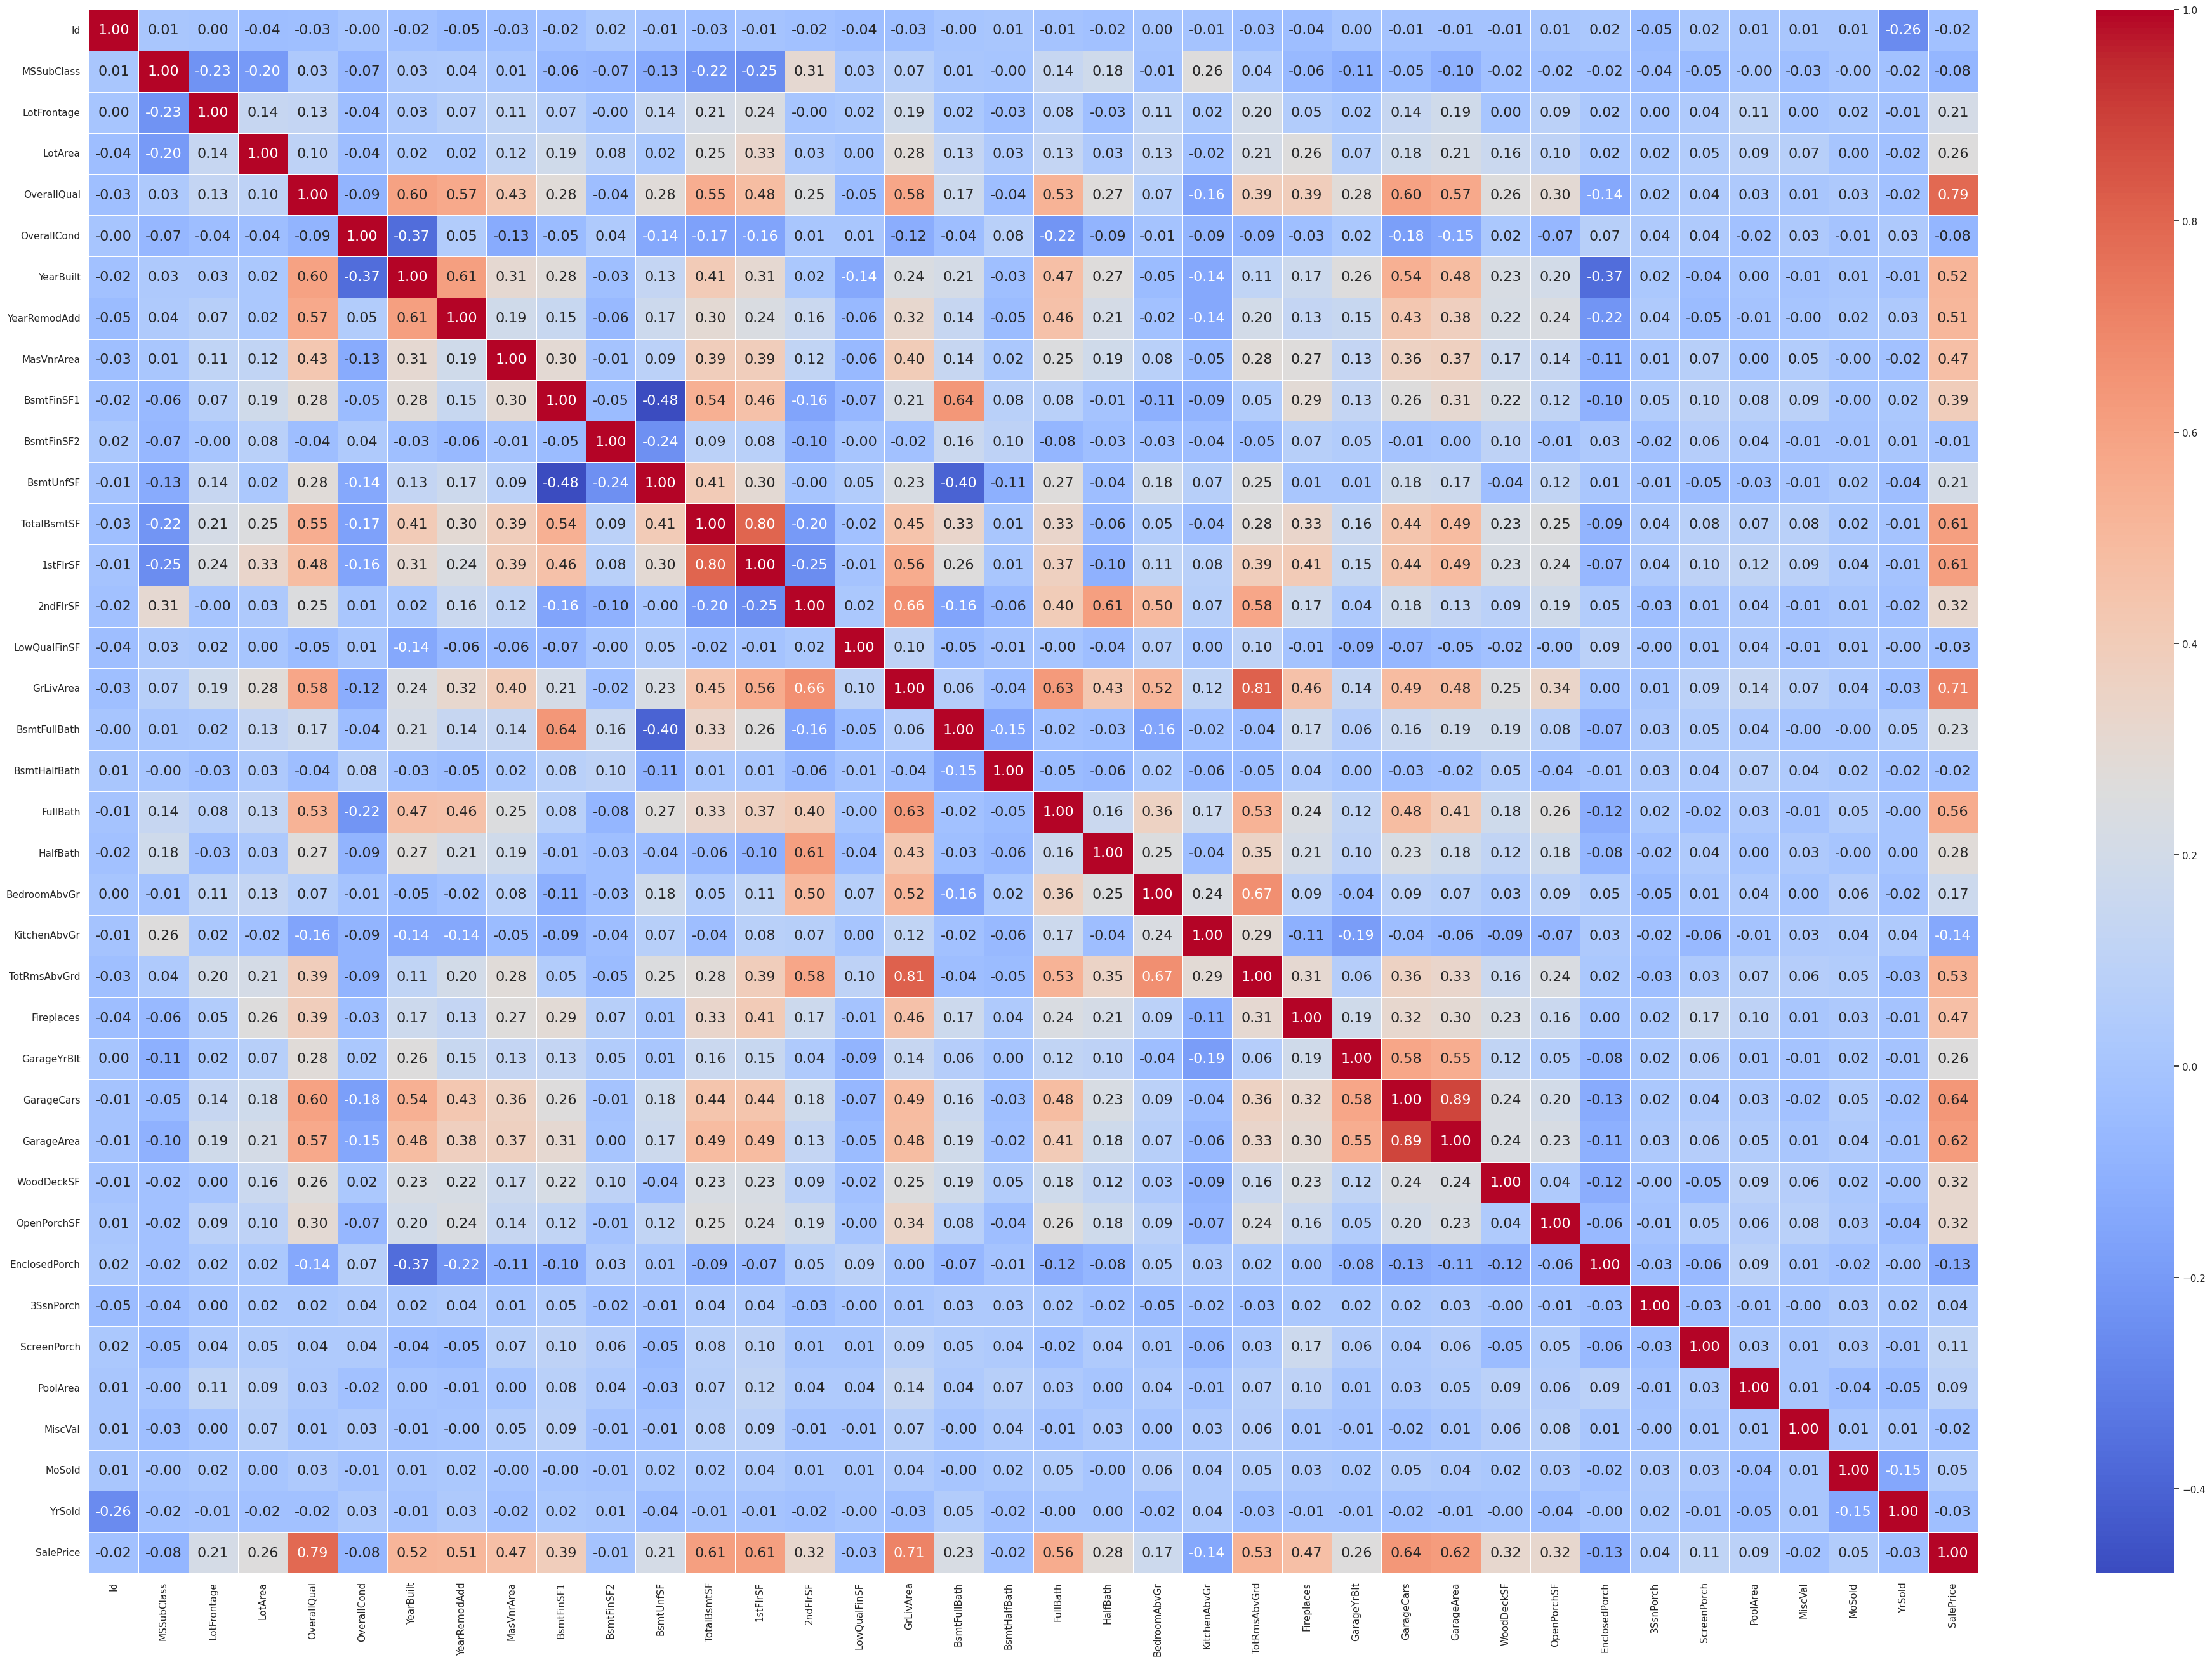

In [87]:
# Look up correlation between numeric features

# Select only numeric columns for calculating the correlation matrix
numerical_df = df_combined.select_dtypes(include='number')

# Calculate the correlation matrix
df_corr = numerical_df.corr().round(2)

# Create a Heatmap
plt.figure(figsize=(48, 32))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt="0.2f", linewidths=0.5, annot_kws={"size": 16})

plt.show()

In [88]:
# Features that have years in them
df_combined['GarageYrBlt'] = df_combined['YrSold'] - df_combined['GarageYrBlt']
df_combined['YearBuilt'] = df_combined['YrSold'] - df_combined['YearBuilt']
df_combined['YearRemodAdd'] = df_combined['YrSold'] - df_combined['YearRemodAdd']

df_combined.drop(['YrSold'], axis=1, inplace=True)
df_combined.drop(['MoSold'], axis=1, inplace=True)

In [89]:
# Features that have square feet
df_combined['BsmtFinSF'] = df_combined['BsmtFinSF1'] + df_combined['BsmtFinSF2']
df_combined['TotalFlrSF'] = df_combined['1stFlrSF'] + df_combined['2ndFlrSF']

df_combined.drop(('BsmtFinSF1'), axis=1, inplace=True)
df_combined.drop(('BsmtFinSF2'), axis=1, inplace=True)
df_combined.drop(('1stFlrSF'), axis=1, inplace=True)
df_combined.drop(('2ndFlrSF'), axis=1, inplace=True)
df_combined.drop(('TotalBsmtSF'), axis=1, inplace=True)

In [90]:
# Features that are about bathrooms
df_combined['TotalBaths'] = df_combined['FullBath'] + (0.5 * df_combined['HalfBath']) + df_combined['BsmtFullBath'] + (0.5 * df_combined['BsmtHalfBath'])

df_combined.drop(['FullBath'], axis=1, inplace=True)
df_combined.drop(['HalfBath'], axis=1, inplace=True)
df_combined.drop(['BsmtFullBath'], axis=1, inplace=True)
df_combined.drop(['BsmtHalfBath'], axis=1, inplace=True)

In [91]:
# Features about the garage
df_combined['GarageAreaPerCar'] = df_combined['GarageArea'] / df_combined['GarageCars']

# Fill in any nulls from feature engineering
df_combined['GarageAreaPerCar'].fillna(0, inplace=True)

df_combined.drop(['GarageArea'], axis=1, inplace=True)
df_combined.drop(['GarageCars'], axis=1, inplace=True)

# Feature Transformation

In [92]:
# Create a list of the numerical data types after the feature engineering
numerical_cols = [cname for cname in df_combined.columns if df_combined[cname].dtypes != 'object' and cname!='SalePrice']

# Create new dataframe with the numerical columns
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])

# This function used to compute the skewness of a dataset
skew_df['Skew'] = skew_df['Feature'].apply(lambda p: scipy.stats.skew(df_combined[p]))

# Change Skew to a postive number
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)

# Create true/false columns based on if Absolute Skew is >=0.5
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda s: True if s >= 0.5 else False )

In [93]:
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,Id,0.000000,0.000000,False
1,MSSubClass,1.375457,1.375457,True
2,LotFrontage,0.022013,0.022013,False
3,LotArea,12.822431,12.822431,True
4,OverallQual,0.197110,0.197110,False
5,OverallCond,0.570312,0.570312,True
6,YearBuilt,0.598609,0.598609,True
7,YearRemodAdd,0.450226,0.450226,False
8,MasVnrArea,2.613592,2.613592,True
9,BsmtUnfSF,0.919339,0.919339,True


In [94]:
# Check if a column has a min of 0 for log transformation
df_combined[numerical_cols].describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFinSF,TotalFlrSF,TotalBaths,GarageAreaPerCar
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,57.766701,10168.114080,6.089072,5.564577,36.479959,23.528263,101.396026,560.579993,4.694416,1500.759849,2.860226,1.044536,6.451524,0.597122,137.497088,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,490.837273,1496.065433,2.218397,257.558056
std,842.787043,42.517628,33.481636,7886.996359,1.409947,1.113131,30.336182,20.892061,178.854579,439.590889,46.396825,506.051045,0.822693,0.214462,1.569379,0.646129,449.665870,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,477.209821,503.675790,0.808840,86.049842
min,1.000000,20.000000,0.000000,1300.000000,1.000000,1.000000,-1.000000,-2.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,2.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,1.000000,0.000000
25%,730.500000,20.000000,43.000000,7478.000000,5.000000,5.000000,7.000000,4.000000,0.000000,220.000000,0.000000,1126.000000,2.000000,1.000000,5.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1120.000000,1.500000,226.500000
50%,1460.000000,50.000000,63.000000,9453.000000,6.000000,5.000000,35.000000,15.000000,0.000000,467.000000,0.000000,1444.000000,3.000000,1.000000,6.000000,1.000000,30.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,457.000000,1440.000000,2.000000,262.666667
75%,2189.500000,70.000000,78.000000,11570.000000,7.000000,6.000000,54.500000,43.000000,163.500000,805.000000,0.000000,1743.500000,3.000000,1.000000,7.000000,1.000000,51.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,805.500000,1742.500000,2.500000,294.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,136.000000,60.000000,1600.000000,2336.000000,1064.000000,5642.000000,8.000000,3.000000,15.000000,4.000000,2010.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,5644.000000,5642.000000,7.000000,924.000000


In [95]:
# Apply log1p transformation to df whose above a 0.5 absolute skew
for column in skew_df.query('Skewed == True')['Feature'].values:
  df_combined[column]=np.log1p(df_combined[column])

In [96]:
# Get list of numerical before starting
num_cols = df_combined.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')
num_cols = num_cols.drop('Id')

In [97]:
# Get list of categorical
categorical_columns_list = df_combined.select_dtypes(include='object').columns

# Create a new Dataframe containing only the categorical columns
df_categorical = df_combined[categorical_columns_list].copy()

df_categorical

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,None,None,None,None,None,Y,None,None,None,WD,Normal
2915,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,None,CarPort,Unf,TA,TA,Y,None,None,None,WD,Abnorml
2916,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
2917,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,Gable,CompShg,HdBoard,Wd Shng,None,TA,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,None,None,None,None,None,Y,None,MnPrv,Shed,WD,Normal


In [98]:
# Label encode all the ordinal data

ordinal_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
              'GarageQual', 'GarageCond', 'PoolQC']

for col in ordinal_1:
  if 'None' in df_combined[col].value_counts().index:
    df_combined[col] = df_combined[col].map({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}).astype('int')
  else:
    df_combined[col] = df_combined[col].map({"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}).astype('int')


In [99]:
# Label encode all the ordinal data individually, and add to list

ordinal_2 = ['LotShape', 'LandContour', 'LandSlope', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
              'Utilities', 'CentralAir', 'Functional', 'GarageFinish', 'PavedDrive', 'Fence']

df_combined['LotShape'] = df_combined['LotShape'].map({"None":0,"IR3":1,"IR2":2,"IR1":3,"Reg":4}).astype('int')
df_combined['LandContour'] = df_combined['LandContour'].map({"None":0,"Low":1,"Bnk":2,"HLS":3,"Lvl":4}).astype('int')
df_combined['LandSlope'] = df_combined['LandSlope'].map({"None":0,"Sev":1,"Mod":2,"Gtl":3}).astype('int')
df_combined['BsmtExposure'] = df_combined['BsmtExposure'].map({"None":0,"No":1,"Mn":2,"Av":3,"Gd":4}).astype('int')
df_combined['BsmtFinType1'] = df_combined['BsmtFinType1'].map({"None":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}).astype('int')
df_combined['BsmtFinType2'] = df_combined['BsmtFinType2'].map({"None":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}).astype('int')
df_combined['Utilities'] = df_combined['Utilities'].map({"None":0,"ELO":1,"NoSeWa":2,"NoSeWr":3,"AllPub":4}).astype('int')
df_combined['CentralAir'] = df_combined['CentralAir'].map({"None":0,"N":1,"Y":2}).astype('int')
df_combined['Functional'] = df_combined['Functional'].map({"None":0,"Sal":1,"Sev":2,"Maj2":3,"Maj1":4,"Mod":5,"Min2":6,"Min1":7,"Typ":8}).astype('int')
df_combined['GarageFinish'] = df_combined['GarageFinish'].map({"None":0,"Unf":1,"RFn":2,"Fin":3}).astype('int')
df_combined['PavedDrive'] = df_combined['PavedDrive'].map({"None":0,"N":1,"P":2,"Y":3}).astype('int')
df_combined['Fence'] = df_combined['Fence'].map({"None":0,"MnWw":1,"GdWo":2,"MnPrv":3,"GdPrv":4}).astype('int')

In [100]:
# Get remaining non-ordinal categorical columns
df_categorical = df_categorical.drop(columns=ordinal_1)
df_categorical = df_categorical.drop(columns=ordinal_2)

# Get the rest of the categorical data for one hot encoding
ohe_ = df_categorical.columns.tolist()

# Convert categorical columns to one-hot encoded columns, dropping the first column for each
df_encoded = pd.get_dummies(df_combined[ohe_], drop_first=True).astype(int)

# Concatenate the one-hot encoded columns with the original Dataframe
df_combined = pd.concat([df_combined.drop(columns=ohe_), df_encoded], axis=1)

# Split Train and Test Data

In [101]:
# Split the data back into train and test sets
df_train = df_combined.iloc[:df_train.shape[0]]
df_test = df_combined.iloc[df_train.shape[0]:]

df_train.drop(['Id'], axis=1, inplace=True)
df_test.drop(['Id', 'SalePrice'], axis=1, inplace=True)

In [102]:
log_target = np.log(df_train['SalePrice'])

df_train.drop(['SalePrice'], axis=1, inplace=True)

# Forming and Testing the Model

In [103]:
best_params_cat = {
    'iterations': 6623,
    'learning_rate':0.01711,
    'depth': 5,
    'eval_metric':'RMSE',
}

best_params_xgb = {
    'n_estimators': 6696,
    'learning_rate': 0.00630,
    'colsample_bytree': 0.22301,
    'subsample': 0.45878,
    'min_child_weight': 3,
}

In [104]:
# Use best parameters to train final models

catboost_model = CatBoostRegressor(**best_params_cat, verbose=0)
xgb_model = XGBRegressor(**best_params_xgb, verbosity=0)

catboost_model.fit(df_train, log_target)
xgb_model.fit(df_train, log_target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.22301, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0063, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=6696,
             n_jobs=None, num_parallel_tree=None, ...)

In [105]:
# Calculate RMSE CatBoost
kf = KFold(n_splits=10)
catboost_rmse = np.exp(np.sqrt(-cross_val_score(catboost_model, df_train, log_target, scoring='neg_mean_squared_error', cv=kf)))

In [106]:
xgb_rmse = np.exp(np.sqrt(-cross_val_score(xgb_model, df_train, log_target, scoring='neg_mean_squared_error', cv=kf)))

In [107]:
# Return average RMSE
print(np.mean(catboost_rmse))
print(np.mean(xgb_rmse))

1.126165250044916
1.1270198058660283


In [108]:
# Combine predictions
final_predictions = (
    0.80 * np.exp(catboost_model.predict(df_test)) +
    0.20 * np.exp(xgb_model.predict(df_test))
)

In [109]:
# Save test predictions to file
output = pd.DataFrame({'Id': df_test.index+1, 'SalePrice': final_predictions})
output.to_csv('submission.csv', index=False)

In [110]:
output

,Id,SalePrice
0,1461,113305.695044
1,1462,164133.195801
2,1463,185681.210447
3,1464,195890.208529
4,1465,187900.286250
...,...,...
1454,2915,82926.575236
1455,2916,77654.378880
1456,2917,156493.023472
1457,2918,115305.456110
